In [ ]:
%reset
import numpy as np
import sys,os
import readgadget
import MAS_library as MASL
import pickle as pk
import readfof
import matplotlib

import matplotlib.pyplot as pl
pl.rc('text', usetex=False)
# Palatino
pl.rc('font', family='DejaVu Sans')
%matplotlib inline


%load_ext Cython

# # This routine computes the density field and save results to file
# def compute_df(snapshot, ptypes, grid, fout):
#     # if not(os.path.exists(snapshot+'.0')) and not(os.path.exists(snapshot+'.0.hdf5')):
#         # return 0
#     print(snapshot)
#     df = MASL.density_field_gadget(snapshot, ptypes, grid, MAS='CIC',
#                                    do_RSD=False, axis=0, verbose=True)
#     df = df/np.mean(df, dtype=np.float64)-1.0
#     np.save(fout, df)
    

    
    


In [3]:
df = np.load('/pscratch/sd/s/spandey/camels/3D_grid/split_IllustrisTNG/Mtot_Nbody/CV/Grids_Mtot_Nbody_IllustrisTNG_CV_512_z=0.0_jv_0.npy') 
# df.shape
ng_in = df.shape[0]
dg_fac = 4
ng_out = df.shape[0]//dg_fac

grid_downgraded = np.mean(df.reshape((ng_out, dg_fac, ng_out, dg_fac, ng_out, dg_fac)), axis=(1, 3, 5))




(0.0, 100.0)

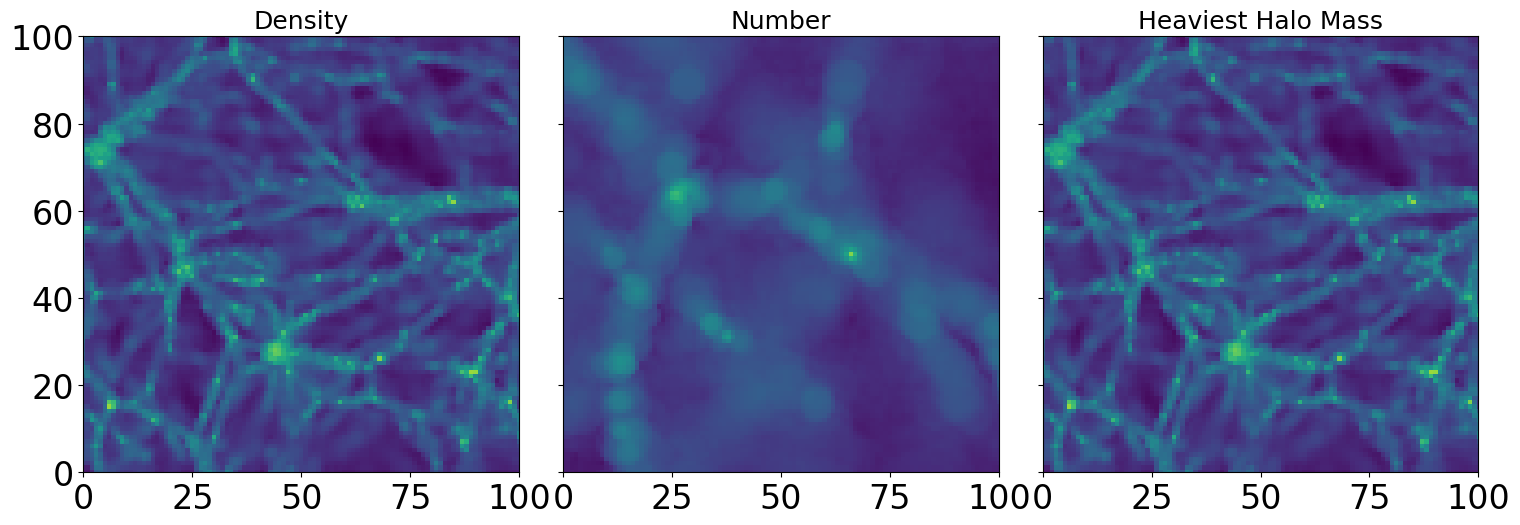

In [7]:
fig, axes = pl.subplots(nrows=1, ncols=3, figsize=(18, 8), sharex=True, sharey=True)
fig.subplots_adjust(wspace=0.1, hspace=0.1)

# axes[0].imshow(((mesh_truth.preview(axes=[0,1]))))
# axes[0].set_title('Truth', size=18)
xmin = 0
xmax = 100
axes[0].imshow(np.log(grid_downgraded[64,:,:]), origin='lower')
axes[0].set_title('Density', size=18)
axes[0].set_xlim(xmin,xmax)
axes[0].set_ylim(xmin,xmax)

axes[1].imshow(np.log(df[256,:,:]), origin='lower')
axes[1].set_title('Number', size=18)
axes[1].set_xlim(xmin,xmax)
axes[1].set_ylim(xmin,xmax)

# axes[2].imshow((np.abs(10**M_halos_truth_recomb[64,:,:,0] - 10**M_halos[64,:,:,0])/10**M_halos_truth_recomb[64,:,:,0]), vmin=0, vmax=1.0, origin='lower')
axes[2].imshow(np.log(grid_downgraded[64,:,:]), origin='lower')
axes[2].set_title('Heaviest Halo Mass', size=18)
axes[2].set_xlim(xmin,xmax)
axes[2].set_ylim(xmin,xmax)





            


In [8]:
# %%cython

# cimport numpy as np
# cpdef void NGP_mass(np.float32_t[:,:] pos, np.float32_t[:] logM, np.float32_t[:,:,:,:] gridM, float BoxSize):

#     cdef int axis,dims,coord,nMmax,jM
#     cdef long i,particles
#     cdef float inv_cell_size
#     cdef int index[3]

#     # find number of particles, the inverse of the cell size and dims
#     particles = pos.shape[0];  coord = pos.shape[1];  dims = gridM.shape[0]; nMmax = gridM.shape[3]
#     inv_cell_size = dims/BoxSize

#     # when computing things in 2D, use the index[2]=0 plane
#     for i in range(3):  index[i] = 0

#     # do a loop over all particles
#     for i in range(particles):
#         for axis in range(coord):
#             index[axis] = <int>(pos[i,axis]*inv_cell_size + 0.5)
#             index[axis] = (index[axis]+dims)%dims
#         for jM in range(nMmax):
#             if gridM[index[0],index[1],index[2], jM] == 0:
#                 gridM[index[0],index[1],index[2], jM] = logM[i]
#                 break
#             else:
#                 pass
        
        
        

In [12]:
# %pip install Pylians
# field = 'Mtot_Nbody'
# field = 'Mtot'
# field = 'Mgas'
# field = 'ne'
# field = 'T'
field = 'P'
root         = '/pscratch/sd/s/spandey/camels/3D_grid/split_IllustrisTNG/%s/CV'%field
root_out     = '/pscratch/sd/s/spandey/camels/3D_grid/split_IllustrisTNG/%s/CV/subvol_NPE'%field
if not(os.path.exists(root_out)):
    os.system('mkdir %s'%root_out)

grids         = [64, 128, 256, 512]
# BoxSize = 1000.0 #Mpc/h ; size of box
n_batch = 8
n_filter = 3
n_cnn_all = [0,3,5]
# n_cnn_all = [3]
# n_sim_tot = 2
n_sim_array = np.arange(0,2)
# snap_num_array = [-1,0,1,2,3,4]
# snap_num_array = [-1]
# i = 0
# print(i)
for ji in n_sim_array:
    print('doing sim: ' + str(ji))
    for grid in grids:
        print('doing res: ' + str(grid))
        z = 0

        # create output folder if it does not exists
        folder_out = '%s/%d'%(root_out,ji)
        if not(os.path.exists(folder_out)):
            os.system('mkdir %s'%folder_out)
        try:
            df_cic = np.load(root + '/Grids_' + field + '_IllustrisTNG_CV_512_z=0.0_jv_' + str(ji) + '.npy')
        except:
            df_cic = np.load(root + '/Grid_' + field + '_IllustrisTNG_CV_512_z=0.0_jv_' + str(ji) + '.npy')
        ng_in = df_cic.shape[0]
        ng_out = grid
        dg_fac = ng_in//ng_out
        if dg_fac > 1:
            df_pylians_cic = np.mean(df_cic.reshape((ng_out, dg_fac, ng_out, dg_fac, ng_out, dg_fac)), axis=(1, 3, 5))
        else:
            df_pylians_cic = df_cic
        print(ng_out, ng_in, dg_fac, df_pylians_cic.shape)

        for n_cnn in n_cnn_all:
            # find name of output file
            savefname_density_subvol = '%s/density_subvol_m_res_%d_z=%s_nbatch_%d_nfilter_%d_ncnn_%d.pk'%(folder_out,grid,z,n_batch,n_filter,n_cnn)
            savefname_density_full = '%s/density_full_m_res_%d_z=%s_nbatch_%d_nfilter_%d_ncnn_%d.pk'%(folder_out,grid,z,n_batch,n_filter,n_cnn)
            print(savefname_density_subvol)
            n_dim_red = (n_filter - 1) // 2
            n_pad = n_dim_red * n_cnn
            if n_cnn > 0:
                df_cic_pad = np.pad(df_pylians_cic, n_pad, 'wrap')
                # df_ngp_pad = np.pad(df_pylians_ngp, n_pad, 'wrap')
            else:
                df_cic_pad = df_pylians_cic
                # df_ngp_pad = df_pylians_ngp

            # we want to split the df_pad into n_batch^3 sub-cubes, but centered on the original df simulation box
            xstart, ystart, zstart = n_pad, n_pad, n_pad
            subvol_size = grid // n_batch + 2 * n_pad
            nsubvol = n_batch**3
            save_subvol_density_cic_pad = np.zeros((nsubvol, subvol_size, subvol_size, subvol_size))
            # save_subvol_density_ngp_pad = np.zeros((nsubvol, subvol_size, subvol_size, subvol_size))
            jc = 0
            from tqdm import tqdm
            for jx in tqdm(range(n_batch)):
                for jy in range(n_batch):
                    for jz in range(n_batch):
                        # get the sub-cube
                        df_sub = df_cic_pad[xstart + jx * grid // n_batch - n_pad:xstart + (jx + 1) * grid // n_batch + n_pad,
                                        ystart + jy * grid // n_batch - n_pad:ystart + (jy + 1) * grid // n_batch + n_pad,
                                        zstart + jz * grid // n_batch - n_pad:zstart + (jz + 1) * grid // n_batch + n_pad]
                        # save the sub-cube
                        save_subvol_density_cic_pad[jc, ...] = df_sub

                        jc += 1

            saved_density_subvol = {
                'density_cic_pad':save_subvol_density_cic_pad,
                # 'density_cic_unpad':save_subvol_density_cic_unpad,
                }                        

            pk.dump(saved_density_subvol, open(savefname_density_subvol, 'wb'))

            saved_density_full = {
                'density_cic_unpad_combined':df_pylians_cic,
                'density_cic_pad_combined':df_cic_pad,
                }                        

            pk.dump(saved_density_full, open(savefname_density_full, 'wb'))


            
                


doing sim: 0
doing res: 64
64 512 8 (64, 64, 64)
/pscratch/sd/s/spandey/camels/3D_grid/split_IllustrisTNG/P/CV/subvol_NPE/0/density_subvol_m_res_64_z=0_nbatch_8_nfilter_3_ncnn_0.pk


100%|██████████| 8/8 [00:00<00:00, 8454.13it/s]


/pscratch/sd/s/spandey/camels/3D_grid/split_IllustrisTNG/P/CV/subvol_NPE/0/density_subvol_m_res_64_z=0_nbatch_8_nfilter_3_ncnn_3.pk


100%|██████████| 8/8 [00:00<00:00, 3120.47it/s]


/pscratch/sd/s/spandey/camels/3D_grid/split_IllustrisTNG/P/CV/subvol_NPE/0/density_subvol_m_res_64_z=0_nbatch_8_nfilter_3_ncnn_5.pk


100%|██████████| 8/8 [00:00<00:00, 2055.78it/s]

doing res: 128


128 512 4 (128, 128, 128)
/pscratch/sd/s/spandey/camels/3D_grid/split_IllustrisTNG/P/CV/subvol_NPE/0/density_subvol_m_res_128_z=0_nbatch_8_nfilter_3_ncnn_0.pk


100%|██████████| 8/8 [00:00<00:00, 2260.93it/s]


/pscratch/sd/s/spandey/camels/3D_grid/split_IllustrisTNG/P/CV/subvol_NPE/0/density_subvol_m_res_128_z=0_nbatch_8_nfilter_3_ncnn_3.pk


100%|██████████| 8/8 [00:00<00:00, 1114.28it/s]


/pscratch/sd/s/spandey/camels/3D_grid/split_IllustrisTNG/P/CV/subvol_NPE/0/density_subvol_m_res_128_z=0_nbatch_8_nfilter_3_ncnn_5.pk


100%|██████████| 8/8 [00:00<00:00, 747.15it/s]


doing res: 256
256 512 2 (256, 256, 256)
/pscratch/sd/s/spandey/camels/3D_grid/split_IllustrisTNG/P/CV/subvol_NPE/0/density_subvol_m_res_256_z=0_nbatch_8_nfilter_3_ncnn_0.pk


100%|██████████| 8/8 [00:00<00:00, 289.89it/s]


/pscratch/sd/s/spandey/camels/3D_grid/split_IllustrisTNG/P/CV/subvol_NPE/0/density_subvol_m_res_256_z=0_nbatch_8_nfilter_3_ncnn_3.pk


100%|██████████| 8/8 [00:00<00:00, 250.88it/s]


/pscratch/sd/s/spandey/camels/3D_grid/split_IllustrisTNG/P/CV/subvol_NPE/0/density_subvol_m_res_256_z=0_nbatch_8_nfilter_3_ncnn_5.pk


100%|██████████| 8/8 [00:00<00:00, 185.69it/s]


doing res: 512
512 512 1 (512, 512, 512)
/pscratch/sd/s/spandey/camels/3D_grid/split_IllustrisTNG/P/CV/subvol_NPE/0/density_subvol_m_res_512_z=0_nbatch_8_nfilter_3_ncnn_0.pk


100%|██████████| 8/8 [00:00<00:00, 38.83it/s]


/pscratch/sd/s/spandey/camels/3D_grid/split_IllustrisTNG/P/CV/subvol_NPE/0/density_subvol_m_res_512_z=0_nbatch_8_nfilter_3_ncnn_3.pk


100%|██████████| 8/8 [00:00<00:00, 40.10it/s]


/pscratch/sd/s/spandey/camels/3D_grid/split_IllustrisTNG/P/CV/subvol_NPE/0/density_subvol_m_res_512_z=0_nbatch_8_nfilter_3_ncnn_5.pk


100%|██████████| 8/8 [00:00<00:00, 33.91it/s]


doing sim: 1
doing res: 64
64 512 8 (64, 64, 64)
/pscratch/sd/s/spandey/camels/3D_grid/split_IllustrisTNG/P/CV/subvol_NPE/1/density_subvol_m_res_64_z=0_nbatch_8_nfilter_3_ncnn_0.pk


100%|██████████| 8/8 [00:00<00:00, 7255.01it/s]


/pscratch/sd/s/spandey/camels/3D_grid/split_IllustrisTNG/P/CV/subvol_NPE/1/density_subvol_m_res_64_z=0_nbatch_8_nfilter_3_ncnn_3.pk


100%|██████████| 8/8 [00:00<00:00, 2854.72it/s]


/pscratch/sd/s/spandey/camels/3D_grid/split_IllustrisTNG/P/CV/subvol_NPE/1/density_subvol_m_res_64_z=0_nbatch_8_nfilter_3_ncnn_5.pk


100%|██████████| 8/8 [00:00<00:00, 2284.63it/s]

doing res: 128


128 512 4 (128, 128, 128)
/pscratch/sd/s/spandey/camels/3D_grid/split_IllustrisTNG/P/CV/subvol_NPE/1/density_subvol_m_res_128_z=0_nbatch_8_nfilter_3_ncnn_0.pk


100%|██████████| 8/8 [00:00<00:00, 3481.11it/s]


/pscratch/sd/s/spandey/camels/3D_grid/split_IllustrisTNG/P/CV/subvol_NPE/1/density_subvol_m_res_128_z=0_nbatch_8_nfilter_3_ncnn_3.pk


100%|██████████| 8/8 [00:00<00:00, 1102.42it/s]


/pscratch/sd/s/spandey/camels/3D_grid/split_IllustrisTNG/P/CV/subvol_NPE/1/density_subvol_m_res_128_z=0_nbatch_8_nfilter_3_ncnn_5.pk


100%|██████████| 8/8 [00:00<00:00, 742.21it/s]


doing res: 256
256 512 2 (256, 256, 256)
/pscratch/sd/s/spandey/camels/3D_grid/split_IllustrisTNG/P/CV/subvol_NPE/1/density_subvol_m_res_256_z=0_nbatch_8_nfilter_3_ncnn_0.pk


100%|██████████| 8/8 [00:00<00:00, 292.57it/s]


/pscratch/sd/s/spandey/camels/3D_grid/split_IllustrisTNG/P/CV/subvol_NPE/1/density_subvol_m_res_256_z=0_nbatch_8_nfilter_3_ncnn_3.pk


100%|██████████| 8/8 [00:00<00:00, 249.83it/s]


/pscratch/sd/s/spandey/camels/3D_grid/split_IllustrisTNG/P/CV/subvol_NPE/1/density_subvol_m_res_256_z=0_nbatch_8_nfilter_3_ncnn_5.pk


100%|██████████| 8/8 [00:00<00:00, 195.32it/s]


doing res: 512
512 512 1 (512, 512, 512)
/pscratch/sd/s/spandey/camels/3D_grid/split_IllustrisTNG/P/CV/subvol_NPE/1/density_subvol_m_res_512_z=0_nbatch_8_nfilter_3_ncnn_0.pk


100%|██████████| 8/8 [00:00<00:00, 38.81it/s]


/pscratch/sd/s/spandey/camels/3D_grid/split_IllustrisTNG/P/CV/subvol_NPE/1/density_subvol_m_res_512_z=0_nbatch_8_nfilter_3_ncnn_3.pk


100%|██████████| 8/8 [00:00<00:00, 40.20it/s]


/pscratch/sd/s/spandey/camels/3D_grid/split_IllustrisTNG/P/CV/subvol_NPE/1/density_subvol_m_res_512_z=0_nbatch_8_nfilter_3_ncnn_5.pk


100%|██████████| 8/8 [00:00<00:00, 33.47it/s]


In [95]:
ji = 0
grid = 128
n_batch = 8
n_filter = 3
n_cnn = n_cnn_all[0]


field = 'Mtot_Nbody'
root_out     = '/pscratch/sd/s/spandey/camels/3D_grid/split_IllustrisTNG/%s/CV/subvol_NPE'%field
folder_out = '%s/%d'%(root_out,ji)
savefname_density_full = '%s/density_subvol_m_res_%d_z=%s_nbatch_%d_nfilter_%d_ncnn_%d.pk'%(folder_out,grid,z,n_batch,n_filter,n_cnn)
df_Mtot_Nbody = (pk.load(open(savefname_density_full, 'rb'))['density_cic_pad'])
# df_Mtot_Nbody.shape
fields = ['Mtot','P']
df_new = np.zeros((df_Mtot_Nbody.shape + (len(fields),)))
df_new.shape


(512, 22, 22, 22, 2)

In [96]:
for jf, field in enumerate(fields):
    print(jf)
    

0
1


In [106]:
# test that all the histograms look like as expected:
ji = 0
grid = 128
n_batch = 8
n_filter = 3
n_cnn = n_cnn_all[0]


field = 'Mtot_Nbody'
root_out     = '/pscratch/sd/s/spandey/camels/3D_grid/split_IllustrisTNG/%s/CV/subvol_NPE'%field
folder_out = '%s/%d'%(root_out,ji)
savefname_density_full = '%s/density_full_m_res_%d_z=%s_nbatch_%d_nfilter_%d_ncnn_%d.pk'%(folder_out,grid,z,n_batch,n_filter,n_cnn)
df_Mtot_Nbody = np.log(pk.load(open(savefname_density_full, 'rb'))['density_cic_unpad_combined'] + 1e-5)
print(np.amin(df_Mtot_Nbody))
field = 'Mtot'
root_out     = '/pscratch/sd/s/spandey/camels/3D_grid/split_IllustrisTNG/%s/CV/subvol_NPE'%field
folder_out = '%s/%d'%(root_out,ji)
savefname_density_full = '%s/density_full_m_res_%d_z=%s_nbatch_%d_nfilter_%d_ncnn_%d.pk'%(folder_out,grid,z,n_batch,n_filter,n_cnn)
df_Mtot = np.log(pk.load(open(savefname_density_full, 'rb'))['density_cic_unpad_combined'] + 1e-5)

field = 'Mgas'
root_out     = '/pscratch/sd/s/spandey/camels/3D_grid/split_IllustrisTNG/%s/CV/subvol_NPE'%field
folder_out = '%s/%d'%(root_out,ji)
savefname_density_full = '%s/density_full_m_res_%d_z=%s_nbatch_%d_nfilter_%d_ncnn_%d.pk'%(folder_out,grid,z,n_batch,n_filter,n_cnn)
df_Mgas = np.log(pk.load(open(savefname_density_full, 'rb'))['density_cic_unpad_combined'] + 1e-5)

print(np.mean(df_Mtot_Nbody), np.mean(df_Mtot), np.mean(df_Mgas))



11.710926
14.334911 23.473558 21.805416


In [107]:
# print(np.mean(df_Mtot_Nbody), np.mean(df_Mtot), np.mean(df_Mgas))

field = 'Mtot_Nbody'
root_out     = '/pscratch/sd/s/spandey/camels/3D_grid/split_IllustrisTNG/%s/CV/subvol_NPE'%field
folder_out = '%s/%d'%(root_out,ji)
savefname_density_full = '%s/density_full_m_res_%d_z=%s_nbatch_%d_nfilter_%d_ncnn_%d.pk'%(folder_out,grid,z,n_batch,n_filter,n_cnn)
df_Mtot_Nbody = np.log(pk.load(open(savefname_density_full, 'rb'))['density_cic_unpad_combined'] + 1e-5)

# print(np.amin(df_Mtot_Nbody))

      
      

(5000.0, 12000.0)

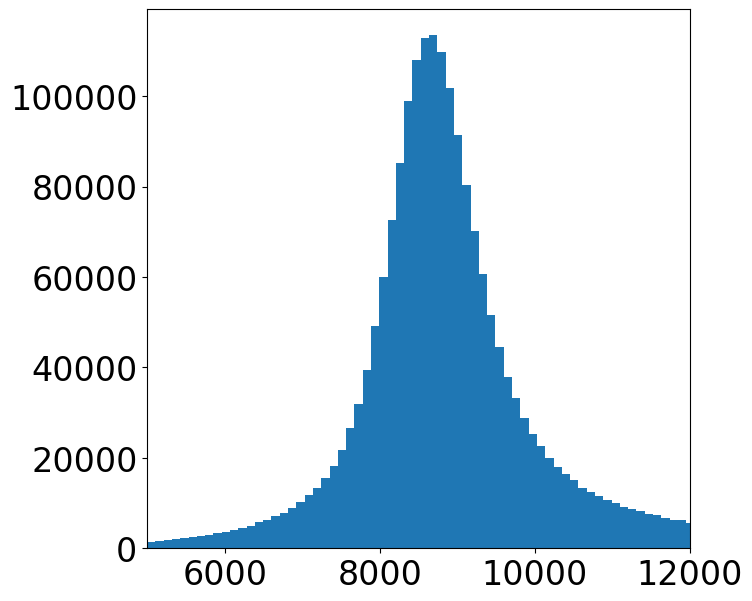

In [108]:
# np.mean(df_Mtot_Nbody), np.mean(df_Mtot)
# ratio = np.exp(df_Mtot)/np.exp(df_Mtot_Nbody)
pl.figure()
_ = pl.hist(ratio.flatten(), bins=5000)
# pl.xscale('log')
pl.xlim(5e3, 1.2e4)
# np.log(1e9)


In [109]:
# test that all the histograms look like as expected:
ji = 1
grid = 128
n_batch = 8
n_filter = 3
n_cnn = n_cnn_all[0]


field = 'ne'
root_out     = '/pscratch/sd/s/spandey/camels/3D_grid/split_IllustrisTNG/%s/CV/subvol_NPE'%field
folder_out = '%s/%d'%(root_out,ji)
savefname_density_full = '%s/density_full_m_res_%d_z=%s_nbatch_%d_nfilter_%d_ncnn_%d.pk'%(folder_out,grid,z,n_batch,n_filter,n_cnn)
df_ne = np.log(pk.load(open(savefname_density_full, 'rb'))['density_cic_unpad_combined'] + 1e-5)

field = 'T'
root_out     = '/pscratch/sd/s/spandey/camels/3D_grid/split_IllustrisTNG/%s/CV/subvol_NPE'%field
folder_out = '%s/%d'%(root_out,ji)
savefname_density_full = '%s/density_full_m_res_%d_z=%s_nbatch_%d_nfilter_%d_ncnn_%d.pk'%(folder_out,grid,z,n_batch,n_filter,n_cnn)
df_T = np.log(pk.load(open(savefname_density_full, 'rb'))['density_cic_unpad_combined'] + 1e-5)

field = 'P'
root_out     = '/pscratch/sd/s/spandey/camels/3D_grid/split_IllustrisTNG/%s/CV/subvol_NPE'%field
folder_out = '%s/%d'%(root_out,ji)
savefname_density_full = '%s/density_full_m_res_%d_z=%s_nbatch_%d_nfilter_%d_ncnn_%d.pk'%(folder_out,grid,z,n_batch,n_filter,n_cnn)
df_P = np.log(pk.load(open(savefname_density_full, 'rb'))['density_cic_unpad_combined'] + 1e-5)




In [110]:
# np.amin(df_Mtot_Nbody)


Text(0, 0.5, 'Histogram')

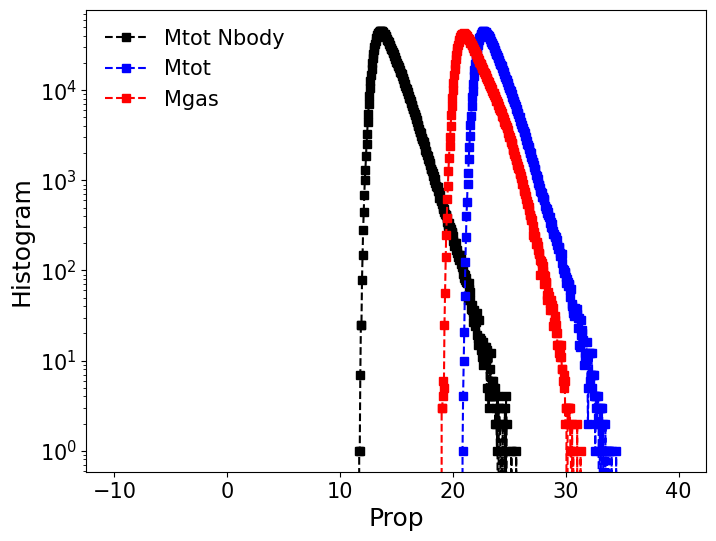

In [111]:
# delta_min_p, delta_max_p = 10.5, 50.4
# indsel_dp = np.where((df_pylians > delta_min_p) & (df_pylians < delta_max_p))
pl.figure(figsize=(8,6))
bin_edges = np.linspace(-10,40,1000)
bin_cents = 0.5*(bin_edges[1:] + bin_edges[:-1])

hist_truth, _ = np.histogram(df_Mtot_Nbody.flatten(), bins=bin_edges)
pl.plot(bin_cents, hist_truth, marker='s', color='k', ls='--', label='Mtot Nbody')

hist_truth, _ = np.histogram(df_Mtot.flatten(), bins=bin_edges)
pl.plot(bin_cents, hist_truth, marker='s', color='b', ls='--', label='Mtot')

hist_truth, _ = np.histogram(df_Mgas.flatten(), bins=bin_edges)
pl.plot(bin_cents, hist_truth, marker='s', color='r', ls='--', label='Mgas')

pl.yscale('log')
pl.legend(fontsize=15, frameon=False)
pl.tick_params(axis='both', which='major', labelsize=15)
pl.tick_params(axis='both', which='minor', labelsize=15)
pl.xlabel(r'Prop', size=18)
pl.ylabel('Histogram', size=18)
# pl.title(str(delta_min_p) + r'$< \delta_m < $' + str(delta_max_p), size=18)




Text(0, 0.5, 'Histogram')

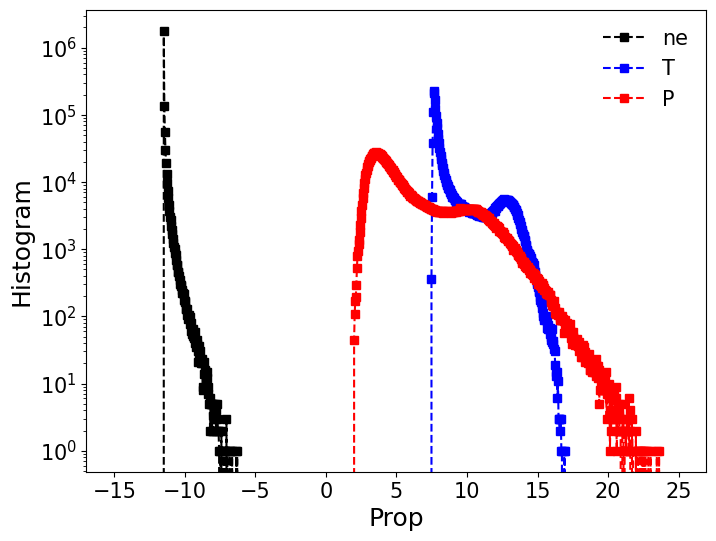

In [63]:
# delta_min_p, delta_max_p = 10.5, 50.4
# indsel_dp = np.where((df_pylians > delta_min_p) & (df_pylians < delta_max_p))
pl.figure(figsize=(8,6))
bin_edges = np.linspace(-15,25,1000)
bin_cents = 0.5*(bin_edges[1:] + bin_edges[:-1])

hist_truth, _ = np.histogram(df_ne.flatten(), bins=bin_edges)
pl.plot(bin_cents, hist_truth, marker='s', color='k', ls='--', label='ne')

hist_truth, _ = np.histogram(df_T.flatten(), bins=bin_edges)
pl.plot(bin_cents, hist_truth, marker='s', color='b', ls='--', label='T')

hist_truth, _ = np.histogram(df_P.flatten(), bins=bin_edges)
pl.plot(bin_cents, hist_truth, marker='s', color='r', ls='--', label='P')

pl.yscale('log')
pl.legend(fontsize=15, frameon=False)
pl.tick_params(axis='both', which='major', labelsize=15)
pl.tick_params(axis='both', which='minor', labelsize=15)
pl.xlabel(r'Prop', size=18)
pl.ylabel('Histogram', size=18)
# pl.title(str(delta_min_p) + r'$< \delta_m < $' + str(delta_max_p), size=18)




(0.0, 100.0)

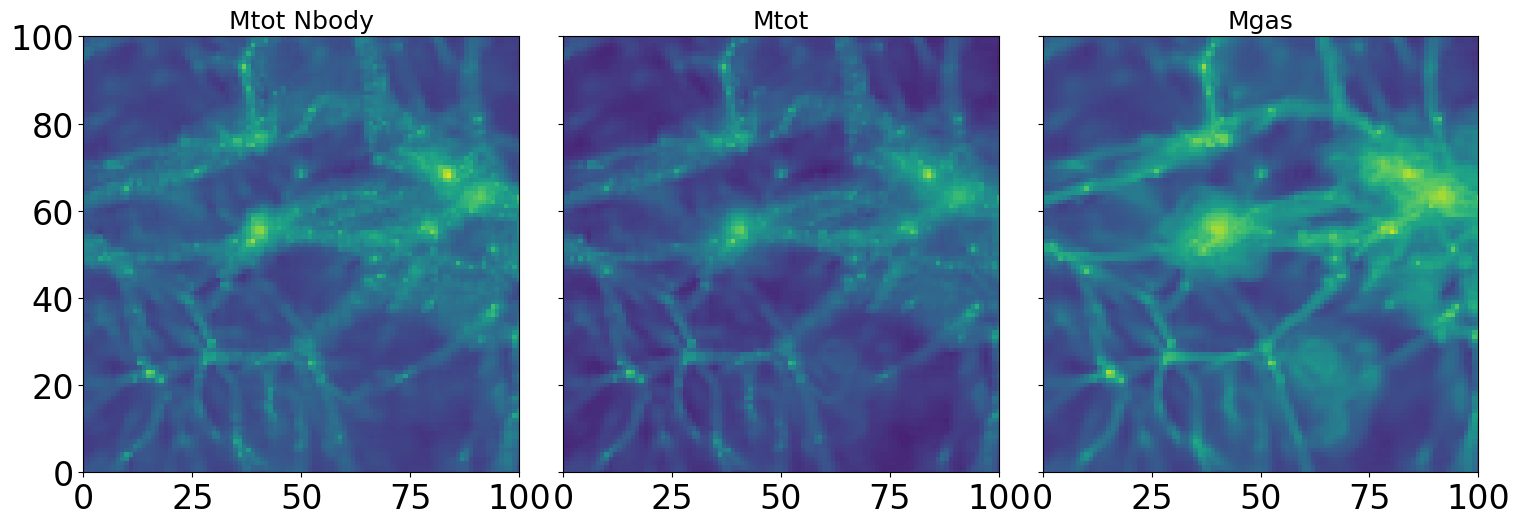

In [66]:
fig, axes = pl.subplots(nrows=1, ncols=3, figsize=(18, 8), sharex=True, sharey=True)
fig.subplots_adjust(wspace=0.1, hspace=0.1)

# axes[0].imshow(((mesh_truth.preview(axes=[0,1]))))
# axes[0].set_title('Truth', size=18)
xmin = 0
xmax = 100
axes[0].imshow(df_Mtot_Nbody[64,:,:], vmin=10, vmax=25, origin='lower')
axes[0].set_title('Mtot Nbody', size=18)
axes[0].set_xlim(xmin,xmax)
axes[0].set_ylim(xmin,xmax)

axes[1].imshow(df_Mtot[64,:,:], vmin=20, vmax=35, origin='lower')
axes[1].set_title('Mtot', size=18)
axes[1].set_xlim(xmin,xmax)
axes[1].set_ylim(xmin,xmax)

# axes[2].imshow((np.abs(10**M_halos_truth_recomb[64,:,:,0] - 10**M_halos[64,:,:,0])/10**M_halos_truth_recomb[64,:,:,0]), vmin=0, vmax=1.0, origin='lower')
axes[2].imshow(df_Mgas[64,:,:], vmin=18, vmax=30, origin='lower')
axes[2].set_title('Mgas', size=18)
axes[2].set_xlim(xmin,xmax)
axes[2].set_ylim(xmin,xmax)





            


(0.0, 100.0)

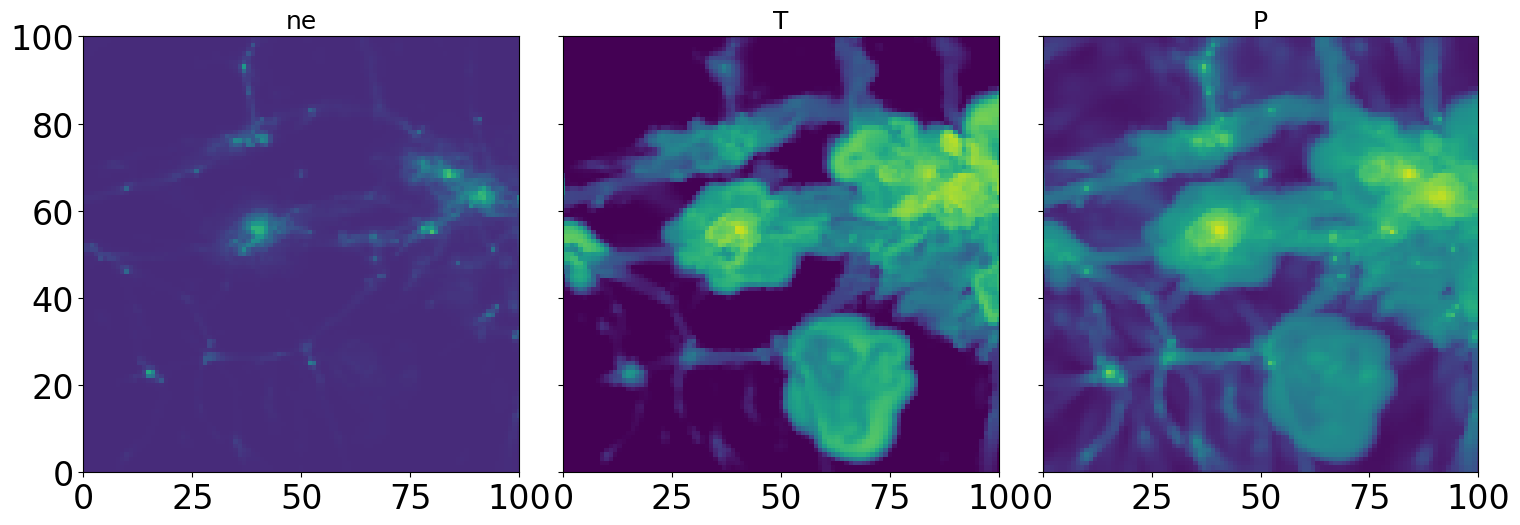

In [72]:
fig, axes = pl.subplots(nrows=1, ncols=3, figsize=(18, 8), sharex=True, sharey=True)
fig.subplots_adjust(wspace=0.1, hspace=0.1)

# axes[0].imshow(((mesh_truth.preview(axes=[0,1]))))
# axes[0].set_title('Truth', size=18)
xmin = 0
xmax = 100
axes[0].imshow(df_ne[64,:,:], vmin=-12, vmax=-8, origin='lower')
axes[0].set_title('ne', size=18)
axes[0].set_xlim(xmin,xmax)
axes[0].set_ylim(xmin,xmax)

axes[1].imshow(df_T[64,:,:], vmin=8, vmax=16, origin='lower')
axes[1].set_title('T', size=18)
axes[1].set_xlim(xmin,xmax)
axes[1].set_ylim(xmin,xmax)

# axes[2].imshow((np.abs(10**M_halos_truth_recomb[64,:,:,0] - 10**M_halos[64,:,:,0])/10**M_halos_truth_recomb[64,:,:,0]), vmin=0, vmax=1.0, origin='lower')
axes[2].imshow(df_P[64,:,:], vmin=2, vmax=20, origin='lower')
axes[2].set_title('P', size=18)
axes[2].set_xlim(xmin,xmax)
axes[2].set_ylim(xmin,xmax)





            


Text(0, 0.5, 'Histogram Density')

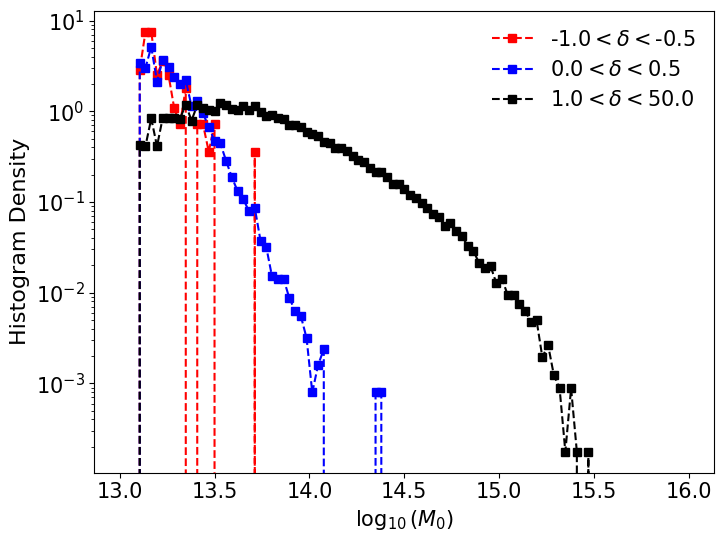

In [36]:
bin_edges = np.linspace(13, 16, 100)
bin_cents = 0.5*(bin_edges[1:] + bin_edges[:-1])


pl.figure(figsize=(8,6))
delta_min_p, delta_max_p = -1.0, -0.5
indsel_dp = np.where((df_pylians > delta_min_p) & (df_pylians < delta_max_p))
hist_truth, _ = np.histogram(dfhalo_ngp_wmass_sorted[...,0][indsel_dp].flatten(), bins=bin_edges, density=True)
pl.plot(bin_cents, hist_truth, marker='s', color='r', ls='--', label=str(delta_min_p) + r'$ < \delta <$' + str(delta_max_p))

delta_min_p, delta_max_p = 0.0, 0.5
indsel_dp = np.where((df_pylians > delta_min_p) & (df_pylians < delta_max_p))
hist_truth, _ = np.histogram(dfhalo_ngp_wmass_sorted[...,0][indsel_dp].flatten(), bins=bin_edges, density=True)
pl.plot(bin_cents, hist_truth, marker='s', color='b', ls='--', label=str(delta_min_p) + r'$ < \delta <$' + str(delta_max_p))


delta_min_p, delta_max_p = 1.0, 50.0
indsel_dp = np.where((df_pylians > delta_min_p) & (df_pylians < delta_max_p))
hist_truth, _ = np.histogram(dfhalo_ngp_wmass_sorted[...,0][indsel_dp].flatten(), bins=bin_edges, density=True)
pl.plot(bin_cents, hist_truth, marker='s', color='k', ls='--', label=str(delta_min_p) + r'$ < \delta <$' + str(delta_max_p))


pl.yscale('log')
pl.legend(fontsize=15, frameon=False)
pl.tick_params(axis='both', which='major', labelsize=15)
pl.tick_params(axis='both', which='minor', labelsize=15)
pl.xlabel(r'$\log_{10}(M_{0})$', size=15)
pl.ylabel('Histogram Density', size=16)
# pl.title(str(delta_min_p) + r'$< \delta_m < $' + str(delta_max_p), size=18)




Text(0.5, 1.0, '1.0$< \\delta_m < $50.0')

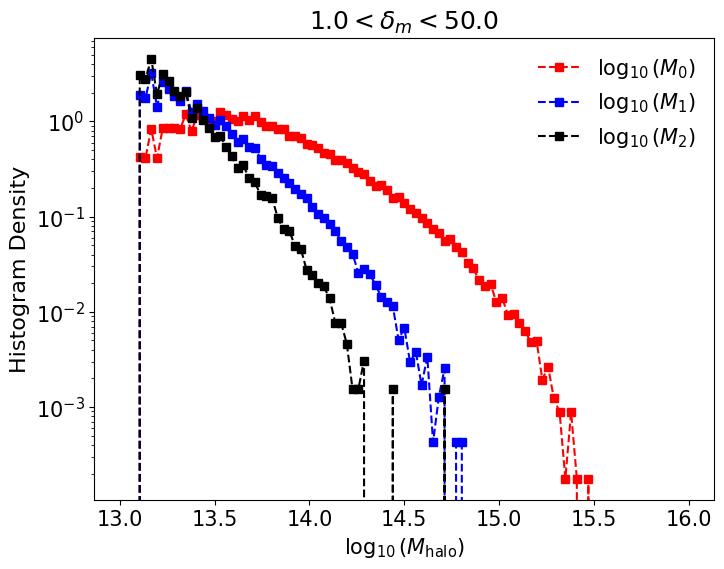

In [37]:
bin_edges = np.linspace(13, 16, 100)
bin_cents = 0.5*(bin_edges[1:] + bin_edges[:-1])


pl.figure(figsize=(8,6))
delta_min_p, delta_max_p = 1.0, 50.0
indsel_dp = np.where((df_pylians > delta_min_p) & (df_pylians < delta_max_p))
hist_truth, _ = np.histogram(dfhalo_ngp_wmass_sorted[...,0][indsel_dp].flatten(), bins=bin_edges, density=True)
pl.plot(bin_cents, hist_truth, marker='s', color='r', ls='--', label=r'$\log_{10}(M_0)$')

hist_truth, _ = np.histogram(dfhalo_ngp_wmass_sorted[...,1][indsel_dp].flatten(), bins=bin_edges, density=True)
pl.plot(bin_cents, hist_truth, marker='s', color='b', ls='--', label=r'$\log_{10}(M_1)$')

hist_truth, _ = np.histogram(dfhalo_ngp_wmass_sorted[...,2][indsel_dp].flatten(), bins=bin_edges, density=True)
pl.plot(bin_cents, hist_truth, marker='s', color='k', ls='--', label=r'$\log_{10}(M_2)$')


pl.yscale('log')
pl.legend(fontsize=15, frameon=False)
pl.tick_params(axis='both', which='major', labelsize=15)
pl.tick_params(axis='both', which='minor', labelsize=15)
pl.xlabel(r'$\log_{10}(M_{\rm halo})$', size=15)
pl.ylabel('Histogram Density', size=16)
pl.title(str(delta_min_p) + r'$< \delta_m < $' + str(delta_max_p), size=18)


